# Assignment description

Build synthetic scale-free networks according to the BA model. Consider $m$ new connections for each node inserted. Calculate empiracally properties like CC and APL. Compare the obtained results for networks of same size generated by Poisson model and WS model. What do you observe?

In [83]:
%config Completer.use_jedi = False

In [84]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Graph parameters

We're going to build some Erdos-Renyi (ER) models varying its parameters. When we fix a connection probability we're also fixing its degree. So we'll create some realizations for each combination of n and z.

In [85]:
def find_percolation_threshold(n = 1000, threshold = 0.5, step = 0.2):
    graphs_dict = dict()
    avg_degree = 0
    while True:
        nodes = n
        graphs_dict[avg_degree] = dict()

        probability = avg_degree/nodes        
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_dict[avg_degree][probability] = graph
        giant = graph.clusters().giant()
        graphs_dict[avg_degree][probability]["giant"] = giant
        giant_fraction = giant.vcount()/n
        avg_degree += step
        if giant_fraction > threshold:
            return graphs_dict

percolations = find_percolation_threshold()

In [86]:
percolations

{0: {0.0: <igraph.Graph at 0x7ffc19f36950>},
 0.2: {0.0002: <igraph.Graph at 0x7ffc19f36850>},
 0.4: {0.0004: <igraph.Graph at 0x7ffc19f36c50>},
 0.6000000000000001: {0.0006000000000000001: <igraph.Graph at 0x7ffc19f36e50>},
 0.8: {0.0008: <igraph.Graph at 0x7ffc194ad150>},
 1.0: {0.001: <igraph.Graph at 0x7ffc194ad350>},
 1.2: {0.0012: <igraph.Graph at 0x7ffc194ad550>},
 1.4: {0.0014: <igraph.Graph at 0x7ffc194ad750>},
 1.5999999999999999: {0.0015999999999999999: <igraph.Graph at 0x7ffc194ad950>}}

# Graph building

## Barabasi-Albert networks

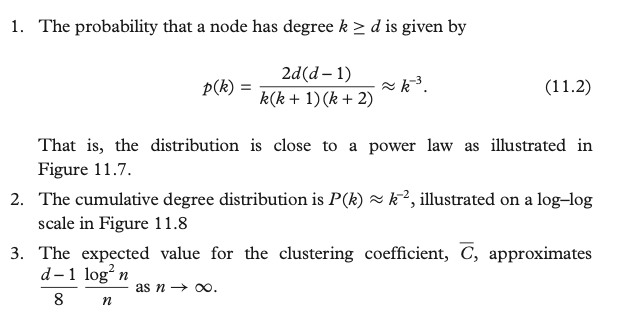

In [87]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
ensemble_size = 10
m_number = np.arange(1, 6, 1)

In [88]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, m_number])

barabasi_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    m_value = int(network_property[1])
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Barabasi(n = nodes, m = m_value)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(m_value) + "_m"
    barabasi_graphs[key] = dict()
    barabasi_graphs[key]['graphs'] = graphs_list
    barabasi_graphs[key]["nodes"] = nodes
    barabasi_graphs[key]["m"] = m_value

CPU times: user 1.25 s, sys: 68.6 ms, total: 1.32 s
Wall time: 1.37 s


In [89]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
m_values = list()
degree_number = list()

for params in barabasi_graphs.keys():
    for graph in barabasi_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(barabasi_graphs[params]["nodes"])
        m_values.append(barabasi_graphs[params]["m"]) 
        edges_number.append(len(graph.get_edgelist()))
        degree_number.append(np.mean(graph.degree()))
        

CPU times: user 8min 39s, sys: 931 ms, total: 8min 40s
Wall time: 8min 43s


In [90]:
barabasi_analysis = pd.DataFrame()
barabasi_analysis["nodes_number"] = nodes_number
barabasi_analysis["avg_degree"] = np.round(degree_number)
barabasi_analysis["m_values"] = m_values
barabasi_analysis["avg_path_length"] = avg_path_length
barabasi_analysis["clustering_coefficient"] = clustering_coefficient

barabasi_analysis.fillna(0, inplace = True)
barabasi_analysis.head()

,nodes_number,avg_degree,m_values,avg_path_length,clustering_coefficient
0,1000,2.0,1,7.545203,0.0
1,1000,2.0,1,8.386048,0.0
2,1000,2.0,1,9.184448,0.0
3,1000,2.0,1,8.711898,0.0
4,1000,2.0,1,9.983247,0.0


In [91]:
barabasi_analysis["avg_degree"].unique()

array([ 2.,  4.,  6.,  8., 10.])

### APL plotting

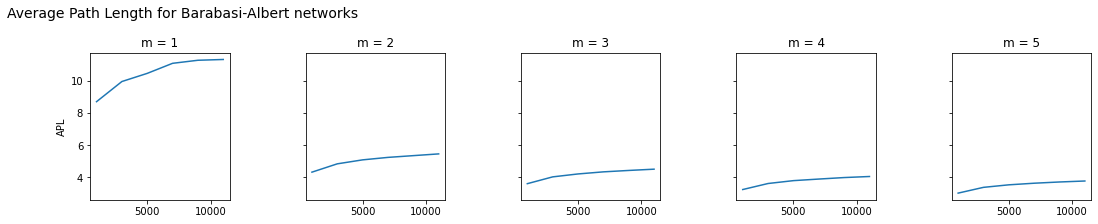

In [92]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "m_values"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

m_values = df_plot["m_values"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["m_values"].isin([m_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"m = {m_values[i]}")
    
_ = ax[0].set_ylabel("APL")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Average Path Length for Barabasi-Albert networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

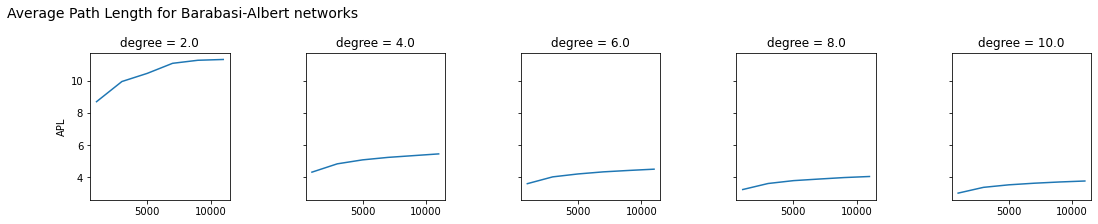

In [93]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = df_plot["avg_degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["avg_degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {degree_values[i]}")
    
_ = ax[0].set_ylabel("APL")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Average Path Length for Barabasi-Albert networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

### Clustering Coefficient plotting

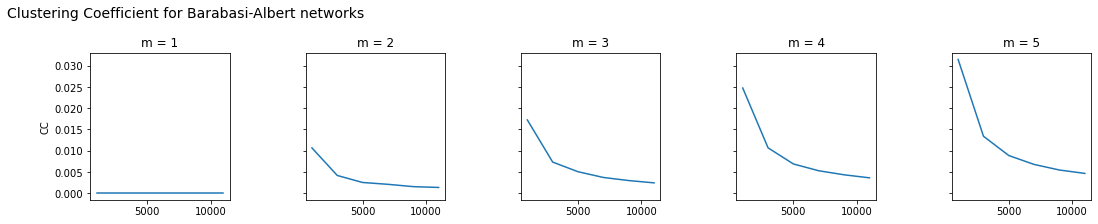

In [94]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "m_values"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

m_values = df_plot["m_values"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["m_values"].isin([m_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "clustering_coefficient")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"m = {m_values[i]}")
    
_ = ax[0].set_ylabel("CC")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Clustering Coefficient for Barabasi-Albert networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

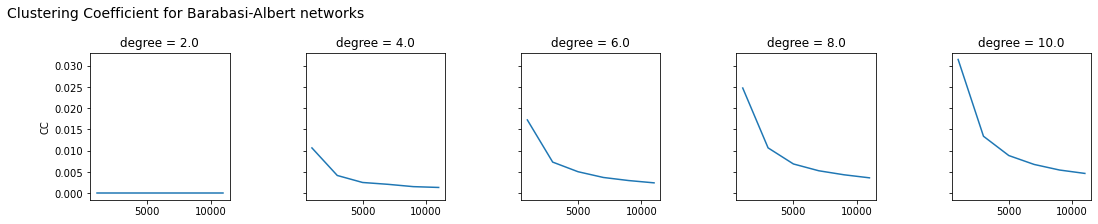

In [95]:
df_plot = barabasi_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = df_plot["avg_degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(m_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(m_values)):
    # Filter the dataset
    data = df_plot[df_plot["avg_degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "clustering_coefficient")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {degree_values[i]}")
    
_ = ax[0].set_ylabel("CC")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Clustering Coefficient for Barabasi-Albert networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

## Poisson networks

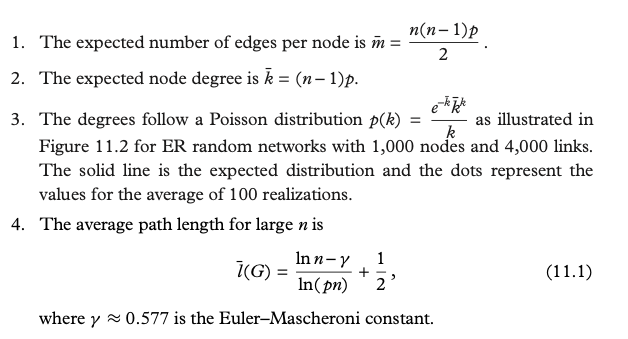

In [96]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
avg_degree_array = [0, 0.5, 0.9, 1, 2, 3, 4, "log", 6, 8, 10] #np.arange(0, 3.2, 0.2)
ensemble_size = 10

In [97]:
# %%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, avg_degree_array])

poisson_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    
    if network_property[1] in ["log", "2log"]:
        degree = np.round(np.log(nodes), 2)
        key = str(nodes) + '_nodes__' + network_property[1] + "_degree"
    else:
        degree = network_property[1]
        key = str(nodes) + '_nodes__' + str(degree) + "_degree"
    probability = degree/nodes
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_list.append(graph)
    
    poisson_graphs[key] = dict()
    poisson_graphs[key]['graphs'] = graphs_list
    poisson_graphs[key]["nodes"] = nodes
    poisson_graphs[key]["degree"] = network_property[1]
    poisson_graphs[key]["probability"] = probability    

In [98]:
%%time
# Calculate some metrics for each graph realization

nodes_number = list()
edges_number = list()
degree_number = list()
clustering_coefficient = list()
avg_path_length = list()
probabilities_values = list()

for params in poisson_graphs.keys():
    for graph in poisson_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        edges_number.append(len(graph.get_edgelist()))
        nodes_number.append(poisson_graphs[params]["nodes"])     
        probabilities_values.append(poisson_graphs[params]["probability"])
        degree_number.append(poisson_graphs[params]["degree"])
        

CPU times: user 13min 45s, sys: 1.38 s, total: 13min 46s
Wall time: 6h 45min 35s


In [99]:
poisson_analysis = pd.DataFrame()

poisson_analysis["nodes_number"] = nodes_number
poisson_analysis["edges_number"] = edges_number
poisson_analysis["degree"] = degree_number
poisson_analysis["probability"] = probabilities_values
poisson_analysis["clustering_coefficient"] = clustering_coefficient
poisson_analysis["avg_path_length"] = avg_path_length

poisson_analysis.head()

,nodes_number,edges_number,degree,probability,clustering_coefficient,avg_path_length
0,1000,0,0,0.0,NaN,NaN
1,1000,0,0,0.0,NaN,NaN
2,1000,0,0,0.0,NaN,NaN
3,1000,0,0,0.0,NaN,NaN
4,1000,0,0,0.0,NaN,NaN


### APL plotting

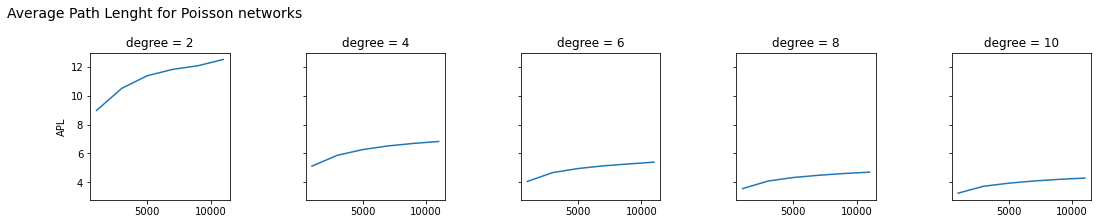

In [100]:
df_plot = poisson_analysis.pivot_table(index = ["nodes_number", "degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = [2, 4, 6, 8, 10]#df_plot["degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(degree_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(degree_values)):
    # Filter the dataset
    data = df_plot[df_plot["degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df_plot[df_plot["degree"].isin(["log"])][("nodes_number")],
#              np.log(df_plot[df_plot["degree"].isin(["log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {degree_values[i]}")
    
_ = ax[0].set_ylabel("APL")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Average Path Lenght for Poisson networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

### Clustering Coefficient plotting

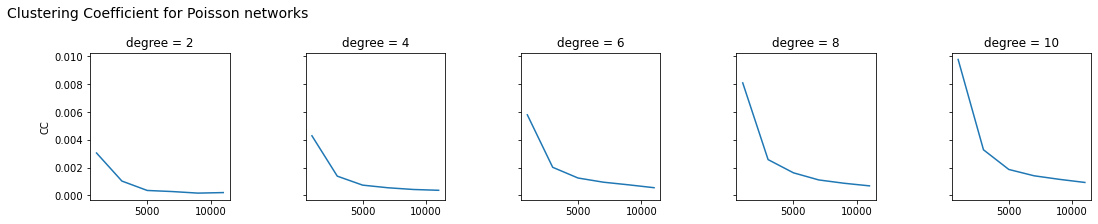

In [101]:
df_plot = poisson_analysis.pivot_table(index = ["nodes_number", "degree"],
                                         values = ['avg_path_length', "clustering_coefficient"],
                                         aggfunc = ["mean"]).reset_index()

degree_values = [2, 4, 6, 8, 10]#df_plot["degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(degree_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(degree_values)):
    # Filter the dataset
    data = df_plot[df_plot["degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "clustering_coefficient")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {degree_values[i]}")
    
_ = ax[0].set_ylabel("CC")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Clustering Coefficient for Poisson networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

## Watts-Strogatz networks

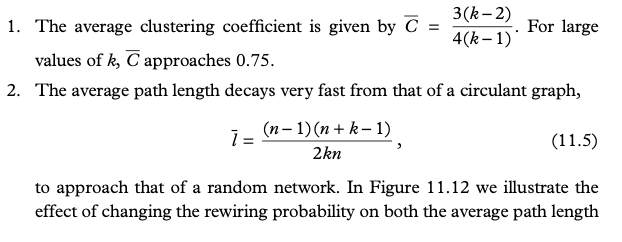

In [102]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]

ensemble_size = 10
steps_number = np.arange(1, 6, 1)
rewiring_probabilities = np.arange(0, 0.3, 0.05)

In [103]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, steps_number, rewiring_probabilities])

watts_strogatz_graphs = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    steps = int(network_property[1])
    rewiring = network_property[2]
    
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Watts_Strogatz(dim = 1, size = nodes, nei = steps, p = rewiring)

        graphs_list.append(graph)

    key = str(nodes) + "_nodes__" + str(steps) + "_nei__" + str(rewiring) + "_rewiring_prob"
    watts_strogatz_graphs[key] = dict()
    watts_strogatz_graphs[key]['graphs'] = graphs_list
    watts_strogatz_graphs[key]["nodes"] = nodes
    watts_strogatz_graphs[key]["rewiring_prob"] = rewiring

CPU times: user 7.72 s, sys: 409 ms, total: 8.13 s
Wall time: 8.17 s


In [104]:
%%time
clustering_coefficient = list()
avg_path_length = list()
nodes_number = list()
edges_number = list()
rewiring_prob_values = list()
degree_number = list()
for params in watts_strogatz_graphs.keys():
    for graph in watts_strogatz_graphs[params]["graphs"]:
        clustering_coefficient.append(graph.transitivity_undirected())
        avg_path_length.append(graph.average_path_length())
        nodes_number.append(watts_strogatz_graphs[params]["nodes"])
        rewiring_prob_values.append(watts_strogatz_graphs[params]["rewiring_prob"]) 
        edges_number.append(len(graph.get_edgelist()))
        degree_number.append(np.mean(graph.degree()))
        
        
watts_strogatz_analysis = pd.DataFrame()
watts_strogatz_analysis["nodes_number"] = nodes_number
watts_strogatz_analysis["avg_degree"] = np.round(degree_number)
watts_strogatz_analysis["rewiring_prob"] = rewiring_prob_values
watts_strogatz_analysis["avg_path_length"] = avg_path_length
watts_strogatz_analysis["clustering_coefficient"] = clustering_coefficient

watts_strogatz_analysis.fillna(0, inplace = True)

KeyboardInterrupt: 

In [105]:
watts_strogatz_analysis["avg_degree"].unique()

array([ 2.,  4.,  6.,  8., 10.])

### APL plotting

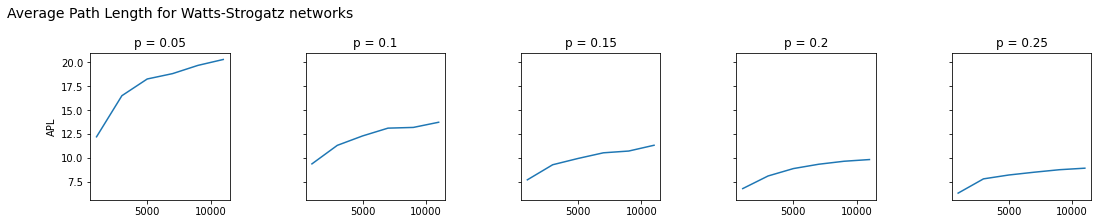

In [106]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

rewiring_values = df_plot["rewiring_prob"].unique()[1:]

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["rewiring_prob"].isin([rewiring_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"p = {np.round(rewiring_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Average Path Length for Watts-Strogatz networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

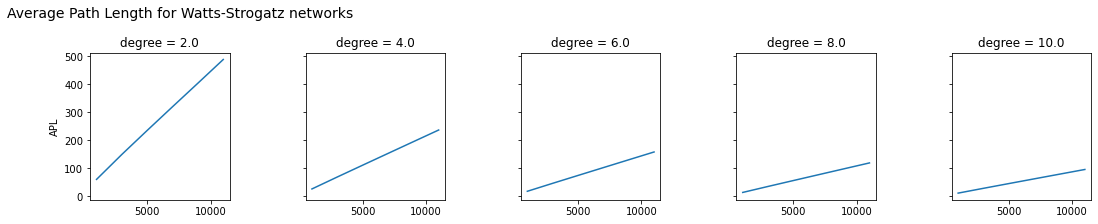

In [107]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

degree_values = df_plot["avg_degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["avg_degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "avg_path_length")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {np.round(degree_values[i], 2)}")
    
_ = ax[0].set_ylabel("APL")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Average Path Length for Watts-Strogatz networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

### Clustering Coefficient plotting

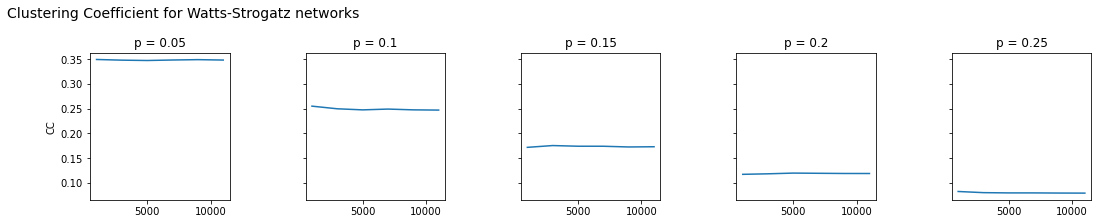

In [108]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "rewiring_prob"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

rewiring_values = df_plot["rewiring_prob"].unique()[1:]

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["rewiring_prob"].isin([rewiring_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "clustering_coefficient")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"p = {np.round(rewiring_values[i], 2)}")
    
_ = ax[0].set_ylabel("CC")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Clustering Coefficient for Watts-Strogatz networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})

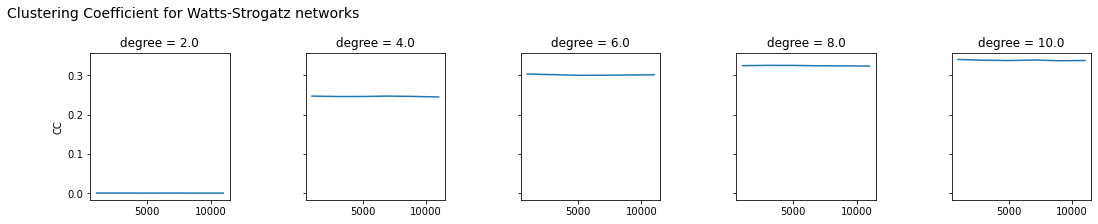

In [109]:
df_plot = watts_strogatz_analysis.pivot_table(index = ["nodes_number", "avg_degree"],
                                   values = ["avg_path_length", "clustering_coefficient"],
                                    aggfunc = ["mean"]
                                   ).reset_index()

degree_values = df_plot["avg_degree"].unique()

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(rewiring_values), figsize = (16, 4),
                       sharey = True)

fig.tight_layout(pad=6)

for i in range(len(rewiring_values)):
    # Filter the dataset
    data = df_plot[df_plot["avg_degree"].isin([degree_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "clustering_coefficient")], )
    
#     # plot logarithm line to comparisons
#     ax2 = ax[i].twinx()
#     ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
#              np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
#              color = "red", 
#              linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"degree = {np.round(degree_values[i], 2)}")
    
_ = ax[0].set_ylabel("CC")
# _ = ax2.set_ylabel("log(n)")
_ = fig.text(0, 0.9, 
             'Clustering Coefficient for Watts-Strogatz networks', 
             fontdict = {'size': 14, 
                         'family': 'DejaVu Sans',})